In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [298]:
df_tr = pd.read_csv('train.csv')
df_tr.drop(df_tr.index[1461],inplace=True)
df_tr.tail()

df_te = pd.read_csv('test.csv')
df_te.head()

df = pd.concat([df_tr,df_te],ignore_index = True)
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [299]:
df.shape

(1575, 5)

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1575 non-null   object 
 1   meantemp      1575 non-null   float64
 2   humidity      1575 non-null   float64
 3   wind_speed    1575 non-null   float64
 4   meanpressure  1575 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.6+ KB


In [301]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [302]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.000000,1575.000000
mean,25.231582,60.420115,6.903642,1010.589745
std,7.337316,16.956083,4.508803,175.298310
min,6.000000,13.428571,0.000000,-3.041667
25%,18.516667,49.750000,3.700000,1001.875000
50%,27.166667,62.380952,6.370000,1009.000000
75%,31.142857,72.125000,9.262500,1015.183333
max,38.714286,98.000000,42.220000,7679.333333


In [0]:
month = [int(d.split('-')[1]) for d in df['date']]
df['month'] = np.array(month)
df['month'] = df['month'].astype('str')
df_ = pd.get_dummies(df['month'],drop_first = True)
df.drop('month',inplace = True,axis = 1)
df = pd.concat([df,df_],axis=1)


winter = [12,1,2]
summer = [3,4,5]
monsoon = [6,7,8,9]
autumn = [10,11]

season = []
for i in month:
  if i in winter:
    season.append('winter')
  elif i in summer:
    season.append('summer')
  elif i in monsoon:
    season.append('monsoon')
  else:
    season.append('autumn')

df['season'] = np.array(season)
df_ = pd.get_dummies(df['season'],drop_first = True)
df.drop('season',inplace = True,axis = 1)

df = pd.concat([df,df_],axis=1)

In [304]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure,10,11,12,2,3,4,5,6,7,8,9,monsoon,summer,winter
1570,2017-04-20,34.500,27.500000,5.562500,998.625000,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1571,2017-04-21,34.250,39.375000,6.962500,999.875000,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1572,2017-04-22,32.900,40.900000,8.890000,1001.600000,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1573,2017-04-23,32.875,27.500000,9.962500,1002.125000,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1574,2017-04-24,32.000,27.142857,12.157143,1004.142857,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [0]:
df['date'] = pd.to_datetime(df['date'])

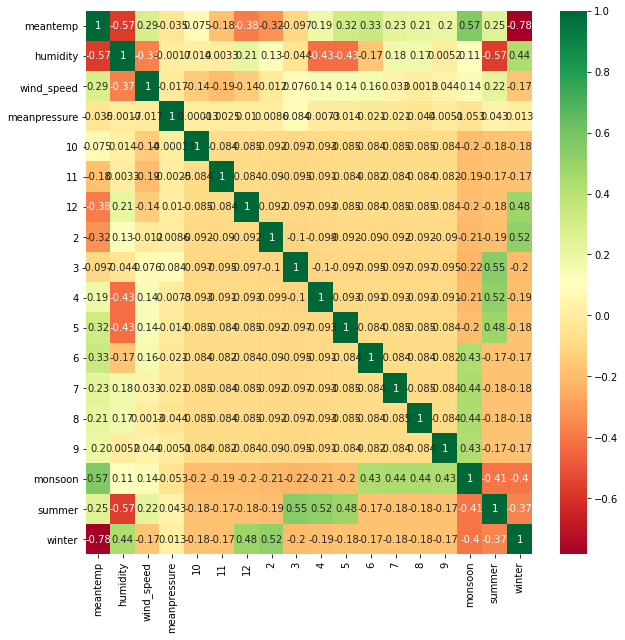

In [306]:
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat["meantemp"])>0.0]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [307]:
continuous_features = [feature for feature in df.columns if len(df[feature].unique())>10 and df[feature].dtype != 'object' and 'date' not in feature]
continuous_features,len(continuous_features)

(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], 4)

In [308]:
sk = df[continuous_features].apply(lambda x:skew(x)).sort_values(ascending = False)
sk = pd.DataFrame(sk)
sk

,0
meanpressure,34.609450
wind_speed,1.374264
humidity,-0.344623
meantemp,-0.374809


In [309]:
ch = [0,0.03,0.05,0.08,0.1,0.13,0.15]
df__ = pd.DataFrame()
for choice in ch:
    df_ = pd.DataFrame(skew(boxcox1p(df[continuous_features],choice)),columns=[choice],index = continuous_features)
    df__ = pd.concat([df__,df_],axis = 1)
    
df__ = pd.concat([pd.DataFrame(skew(df[continuous_features]),columns = ['Org'],index = continuous_features),df__],axis = 1)


skew_result = {}
for i in df__.index:
    min_ = 'Org'
    for j in df__.columns:
        if df__.loc[i,j]>=0 and df__.loc[i,j]<df__.loc[i,min_]:
            min_ = j
            
    skew_result[i] = min_
    

print(skew_result)
skew_result = {k:v for k,v in skew_result.items() if v != 'Org'}

{'meantemp': 'Org', 'humidity': 'Org', 'wind_speed': 'Org', 'meanpressure': 'Org'}


In [0]:
df_ = df.copy()
df_train = df_.iloc[:-20,:]
df_test = df_.iloc[-20:,:]

In [0]:
df_train.drop('date',axis = 1,inplace = True)

In [0]:
df_train['label'] = df_train['meantemp'].shift(-20)
df_train_test = df_train.iloc[-20:,:]
df_train = df_train.iloc[:-20,:]

In [0]:
x_train = df_train.drop('label',axis = 1)
y_train = df_train['label']
x_train_test = df_train_test.drop('label',axis = 1)

In [0]:
def rsc(x_train,x_train_test):
  sc = RobustScaler()
  x_train[['humidity','wind_speed','meanpressure','monsoon','summer','winter']] = sc.fit_transform(x_train[['humidity','wind_speed','meanpressure','monsoon','summer','winter']])
  x_train_test[['humidity','wind_speed','meanpressure','monsoon','summer','winter']] = sc.transform(x_train_test[['humidity','wind_speed','meanpressure','monsoon','summer','winter']])
  return x_train,x_train_test
  x_train,x_train_test = rsc(x_train,x_train_test)

In [322]:
model = XGBRegressor(n_estimators=300,learning_rate=0.05)
model.fit(x_train,y_train)
pre = model.predict(x_train_test)

[12:04:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(array([736424., 736426., 736428., 736430., 736432., 736434., 736436.,
        736438., 736440., 736442.]),
 <a list of 10 Text major ticklabel objects>)

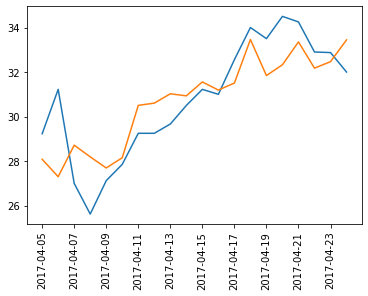

In [323]:
plt.plot_date(df_test['date'],df_test['meantemp'],'-')
plt.plot_date(df_test['date'],pre,'-')
plt.xticks(rotation=90)